In [1]:
import sys, os
sys.path.append(os.getcwd() + '/..')
import src

# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
import gym


%matplotlib inline
%env THEANO_FLAGS="floatX=float32"

env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "FrontoPolarStocks-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 3
SEQ_LENGTH = 10

In [4]:
env = gym.make(GAME)
env.reset()

obs = env.step(0)[0]

action_names = np.array(["sell", "pass", "buy"]) #i guess so... i may be wrong
state_size = len(obs)

print(obs)

[2017-05-07 17:53:43,510] Making new env: FrontoPolarStocks-v0


[ 0.349999 -2.459999  0.299999 -0.149998 -0.900001]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [5]:
import lasagne

In [6]:
from agent import build_agent

In [7]:
agent, action_layer, V_layer = build_agent(env, state_size)

In [8]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [9]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent, GAME, N_AGENTS, max_size=10000)


[2017-05-07 17:53:44,646] Making new env: FrontoPolarStocks-v0
[2017-05-07 17:53:44,667] Making new env: FrontoPolarStocks-v0
[2017-05-07 17:53:44,687] Making new env: FrontoPolarStocks-v0


In [10]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['pass' 'buy' 'pass' 'pass' 'pass' 'pass' 'sell']
 ['sell' 'sell' 'pass' 'sell' 'pass' 'pass' 'pass']
 ['sell' 'sell' 'buy' 'pass' 'sell' 'sell' 'sell']]
[[ 0.       -1.3131    0.        0.        0.        0.        0.      ]
 [ 0.       -0.200601  0.       -0.5906    0.        0.        0.      ]
 [ 0.       -0.1006    0.1594    0.       -0.6606    0.4194    0.      ]]
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 15.8 ms


In [11]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# a2c loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [12]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100, replace=True)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [13]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import a2c


#Train via actor-critic (see here - https://www.youtube.com/watch?v=KHZVXao4qXs)

elwise_mse_loss = a2c.get_elementwise_objective(policy_seq,V_seq[:,:,0],
                                                       replay.actions[0],
                                                       replay.rewards,
                                                       replay.is_alive,
                                                       gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [14]:
from theano import tensor as T
reg = T.mean((1./policy_seq).sum(axis=-1))
loss += 0.001*reg

In [15]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.001)

In [16]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)


WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2017-05-07 17:53:49,167] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


# Demo run

In [17]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-05-07 17:53:49,475] Making new env: FrontoPolarStocks-v0
[2017-05-07 17:53:49,496] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-05-07 17:53:49,498] Starting new video recorder writing to /home/manatee/Desktop/inn.prac/Algorithms/src/records/openaigym.video.0.24161.video000000.mp4
[2017-05-07 17:53:56,409] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/manatee/Desktop/inn.prac/Algorithms/src/records')


Episode finished after 400 timesteps with reward=-3.3018030000000276


In [18]:
from IPython.display import HTML

video_path="<fill in url from above>"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Vime

In [19]:
from bnn import bbpwrap, NormalApproximation,sample_output
from lasagne.layers import InputLayer, DenseLayer, EmbeddingLayer
import theano.tensor as T
@bbpwrap(NormalApproximation())
class BayesDenseLayer(DenseLayer):pass
@bbpwrap(NormalApproximation())
class BayesEmbLayer(EmbeddingLayer):pass

from curiosity import compile_vime_reward


# FIXME : cant see class attribute
target_rho = 1
class BNN:
    curiosity=0.01
    target_rho = 1
    
    l_state = InputLayer((None, state_size),name='state var')
    l_action = InputLayer((None,), input_var=T.ivector())

    l_action_emb = BayesEmbLayer(l_action, env.action_space.n, 3)    
    
    l_concat = lasagne.layers.concat([l_action_emb, l_state])
    
    l_dense = BayesDenseLayer(l_concat, num_units=50,
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    l_out = BayesDenseLayer(l_dense, num_units=state_size,
                            nonlinearity=None)
        
    params = lasagne.layers.get_all_params(l_out, trainable=True)
    ###training###
    pred_states = lasagne.layers.get_output(l_out)
    next_states = T.matrix("next states")
    mse = lasagne.objectives.squared_error(pred_states, next_states).mean()
    
    #replace logposterior with simple regularization on rho cuz we're lazy
    reg = sum([lasagne.objectives.squared_error(rho, target_rho).mean() 
              for rho in lasagne.layers.get_all_params(l_out, rho=True)])
    
    loss = mse+ 0.01*reg
    
    updates = lasagne.updates.adam(loss,params)
    
    train_step = theano.function([l_state.input_var,l_action.input_var,next_states],
                                 loss,updates=updates)
    
    ###sample random sessions from pool###
    observations, = replay.observations
    actions, = replay.actions
    observations_flat = observations[:,:-1].reshape((-1,)+tuple(observations.shape[2:]))
    actions_flat = actions[:,:-1].reshape((-1,))
    next_observations_flat = observations[:,1:].reshape((-1,)+tuple(observations.shape[2:]))
    sample_from_pool = theano.function([],[observations_flat,actions_flat,next_observations_flat])

    
    ###curiosity reward### aka KL(qnew,qold)
    get_vime_reward_elwise = compile_vime_reward(l_out,l_state,l_action,params,n_samples=10)
    
    vime_reward_ma = 10.
    @staticmethod
    def add_vime_reward(observations,actions,rewards,is_alive,h0):
        assert isinstance(observations, np.ndarray)
        observations_flat = observations[:,:-1].reshape((-1,)+observations.shape[2:]).astype('float32')
        actions_flat = actions[:,:-1].reshape((-1,)).astype('int32')
        next_observations_flat = observations[:,1:].reshape((-1,)+observations.shape[2:]).astype('float32')

        vime_rewards = BNN.get_vime_reward_elwise(observations_flat,actions_flat,next_observations_flat)
        vime_rewards = np.concatenate([vime_rewards.reshape(rewards[:,:-1].shape),
                                       np.zeros_like(rewards[:,-1:]),], axis=1)
        #normalize by moving average
        BNN.vime_reward_ma = 0.99*BNN.vime_reward_ma + 0.01*vime_rewards.mean()
        
        surrogate_rewards = rewards + BNN.curiosity/BNN.vime_reward_ma*vime_rewards
        return (observations,actions,surrogate_rewards,is_alive,h0)
    
        


# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [21]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

#pre-train BNN (mitigate training lag on first iterations where BNN is stupid)
for i in tqdm(range(1000)):
    BNN.train_step(*BNN.sample_from_pool())


100%|██████████| 1000/1000 [00:03<00:00, 264.42it/s]


In [22]:

#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in tqdm(range(1000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

    for i in range(10):
        loss = loss*0.99 + train_step()*0.01
    
    for i in range(10):
        BNN.train_step(*BNN.sample_from_pool())

    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\treward/step=%.5f\tpool_size=%i\tvime ma=%.5f"%(epoch_counter,
                                                         pool_mean_reward,
                                                         pool_size,
                                                         BNN.vime_reward_ma))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

 10%|█         | 100/1000 [00:42<05:38,  2.66it/s]

iter=100	reward/step=0.14601	pool_size=6003	vime ma=0.76898


 20%|██        | 200/1000 [01:22<06:19,  2.11it/s]

iter=200	reward/step=0.30519	pool_size=9003	vime ma=0.61206


 30%|███       | 300/1000 [02:09<05:11,  2.25it/s]

iter=300	reward/step=0.50917	pool_size=10000	vime ma=0.61925


 40%|████      | 400/1000 [02:51<04:06,  2.43it/s]

iter=400	reward/step=0.64691	pool_size=10000	vime ma=0.58809


 50%|████▉     | 499/1000 [03:33<03:19,  2.51it/s][2017-05-07 17:58:14,313] Making new env: FrontoPolarStocks-v0
[2017-05-07 17:58:14,332] Clearing 4 monitor files from previous run (because force=True was provided)


iter=500	reward/step=0.65092	pool_size=10000	vime ma=0.17855


[2017-05-07 17:58:14,894] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/manatee/Desktop/inn.prac/Algorithms/src/records')
 50%|█████     | 500/1000 [03:34<04:47,  1.74it/s]

Current score(mean over 10) = 208.768


 60%|██████    | 600/1000 [04:15<02:47,  2.38it/s]

iter=600	reward/step=0.64115	pool_size=10000	vime ma=0.25522


 70%|███████   | 700/1000 [04:57<02:01,  2.46it/s]

iter=700	reward/step=0.67854	pool_size=10000	vime ma=0.16832


 80%|████████  | 800/1000 [05:39<01:21,  2.47it/s]

iter=800	reward/step=0.70874	pool_size=10000	vime ma=0.32488


 90%|█████████ | 900/1000 [06:19<00:40,  2.49it/s]

iter=900	reward/step=0.72600	pool_size=10000	vime ma=0.24041


100%|█████████▉| 999/1000 [06:59<00:00,  2.38it/s][2017-05-07 18:01:41,101] Making new env: FrontoPolarStocks-v0
[2017-05-07 18:01:41,120] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	reward/step=0.72418	pool_size=10000	vime ma=0.22546


[2017-05-07 18:01:41,683] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/manatee/Desktop/inn.prac/Algorithms/src/records')
100%|██████████| 1000/1000 [07:00<00:00,  1.67it/s]

Current score(mean over 10) = 265.000


In [23]:
iters, session_rewards=zip(*sorted(rewards.items(),key=lambda pr:pr[0]))

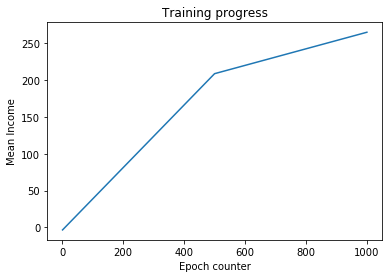

In [29]:
plt.plot(iters,list(map(np.mean, session_rewards)))
plt.title("Training progress")
plt.xlabel("Epoch counter")
plt.ylabel("Mean Income")
plt.show()

In [30]:
_,_,_,_,(pool_policy,pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,)

states = pool.experience_replay.observations[0].get_value().reshape((-1, 5)).T[-2:]
values = pool_V.ravel().eval()
optimal_actid = pool_policy.argmax(-1).ravel().eval()


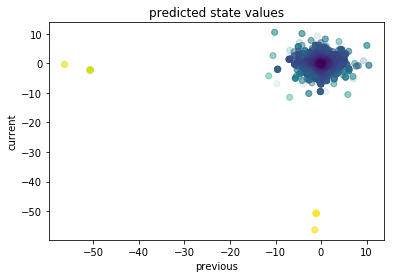

In [31]:
plt.scatter(
    *states,
    c=values,
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("previous")
plt.ylabel("current")
plt.show()

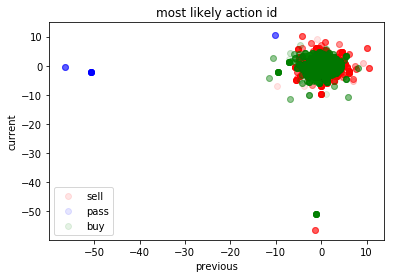

In [32]:
obs_x, obs_y = states

for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("previous")
plt.ylabel("current")
plt.legend(loc='best')
plt.show()

In [33]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-05-07 18:03:12,364] Making new env: FrontoPolarStocks-v0
[2017-05-07 18:03:12,383] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-05-07 18:03:12,385] Starting new video recorder writing to /home/manatee/Desktop/inn.prac/Algorithms/src/records/openaigym.video.4.24161.video000000.mp4
[2017-05-07 18:03:19,236] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/manatee/Desktop/inn.prac/Algorithms/src/records')


Episode finished after 400 timesteps with reward=355.2309309999994
